In [1]:
import matplotlib.pyplot as plt
import numpy as np
from lowEBMs.Packages.Configuration import importer, add_sellersparameters, parameterinterpolatorstepwise, reset
from lowEBMs.Packages.Configuration import import_parallelparameter, allocate_parallelparameter, write_parallelparameter
from lowEBMs.Packages.Variables import variable_importer
from lowEBMs.Packages.RK4 import rk4alg
from lowEBMs.Packages.ModelEquation import model_equation
from lowEBMs.Packages.Variables import Vars,reset, trackerreset, datareset
from lowEBMs.Packages.Functions import plotmeanstd
from lowEBMs import update_plotstyle, moving_average
import lowEBMs.Packages.Constants as const

import builtins
import matplotlib
update_plotstyle()
matplotlib.rcParams['lines.linewidth']=1.1

In [2]:
Lat_10,ZMT_10=np.loadtxt('Data/ERA_ZMT_Mean_10deginterpolated.txt')
Lat_ERA,ZMT_ERA=np.loadtxt('Data/ERA_ZMT_Mean.txt')

In [3]:
def coremodule(config,P0,P_pert_ratio,Pmin,Pmax,labels,ZMT,GMT,grid,maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_paras,gamma0,control,controlconfig):
    from tqdm import tqdm, tnrange
    
    F=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,2*num_paras+1))
    dF=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    P=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    Ptrans=np.reshape(np.zeros(maxlength*(num_paras)),(maxlength,num_paras))
    gamma=np.zeros(maxlength)
    
    if targetmode=='Single':
        dataout=np.reshape(np.zeros(maxlength*(2*num_paras+1)),(maxlength,(2*num_paras+1)))
    elif targetmode=='ZMT':
        dataout=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
    elif targetmode=='GMT':
        dataout=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))
    elif targetmode=='Coupled':
        dataout_ZMT=np.reshape(np.zeros(maxlength*len(grid)*(2*num_paras+1)),(maxlength,(2*num_paras+1),len(grid)))
        dataout_GMT=np.reshape(np.zeros(maxlength*int(number_of_integration/data_readout)*(2*num_paras+1)),(maxlength,(2*num_paras+1),int(number_of_integration/data_readout)))     
    for i in tnrange(maxlength):
        print('Iteration no.'+str(i))
        if i==0:
            P[i]=P0
            P_pert=(Pmax-Pmin)*P_pert_ratio
            Ptrans[i]=(P0-Pmin)/(Pmax-Pmin)
            Ptrans_pert=Ptrans[i]*P_pert_ratio

        if targetmode=='Coupled':
            data_ZMT,data_GMT=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout_ZMT[i]=data_ZMT
            dataout_GMT[i]=data_GMT
        else:
            data=run_model(config,P[i],P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation)
            dataout[i]=data
            
        if targetmode=='Coupled':
            target_ZMT=target['ZMT']
            target_GMT=target['GMT']
            F_ZMT=target_comparison(data_ZMT,'ZMT',target_ZMT,targetfunction,num_paras,grid)
            F_GMT=target_comparison(data_GMT,'GMT',target_GMT,targetfunction,num_paras,grid)
            F[i]=ratio_ZMT_GMT*F_ZMT+(1-ratio_ZMT_GMT)*F_GMT
        else:
            F[i]=target_comparison(data,targetmode,target,targetfunction,num_paras,grid)

        dF[i]=local_gradient(F[i],Ptrans_pert)
        #dF[i]=local_gradient(F[i],P_pert)
        if i==0:
            gamma[i]=gamma0
        else:
            #gamma[i]=step_weighting(dF[i-1],dF[i],P[i-1],P[i])
            gamma[i]=step_weighting(dF[i-1],dF[i],Ptrans[i-1],Ptrans[i])
            
        if precision_check(dF[0],dF[i],precision):
            print('stop',i)
            P=P[:i]
            Ptrans=Ptrans[:i]
            F=F[:i]
            dF=dF[:i]
            gamma=gamma[:i]
            break
                
        #P_next=new_parameters(P[i],gamma[i],dF[i])        
        Ptrans_next=new_parameters(Ptrans[i],gamma[i],dF[i])

        for k in range(num_paras):
            if Ptrans_next[k]<0:
                Ptrans_next[k]=0.
            if Ptrans_next[k]>1:
                Ptrans_next[k]=1.

        if i<maxlength-1:
            Ptrans[i+1]=Ptrans_next
            P[i+1]=Pmin+Ptrans_next*(Pmax-Pmin)
            print(F[i])
            print(gamma[i])
            print(P[i+1])
            
        if targetmode=='Coupled':
            dataout=[dataout_ZMT,dataout_GMT]
            
    return F, dF, P , Ptrans, gamma, dataout
    
def target_comparison(data,targetmode,target,targetfunction,num_paras,grid):
    F=np.zeros(2*num_paras+1)
    if targetfunction=='LeastSquare':
        if targetmode=='Single':
            F=(np.array(data)-target)**2
        elif targetmode=='ZMT':
            for i in range(len(F)):
                if len(data[i])==len(target):
                    F[i]=np.sum(((data[i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
                elif len(data[i])==len(F):
                    F[i]=np.sum(((data[:,i]-target)*np.cos(grid*np.pi/180)/np.mean(np.cos(grid*np.pi/180)))**2)
        elif targetmode=='GMT':
            for i in range(len(F)):
                F[i]=np.sum((data[i]-target)**2)

    return F

def local_gradient(F,P_pert):
    dF=np.zeros(len(P_pert))
    for k in range(len(P_pert)):
        dF[k]=(F[2*(k+1)-1]-F[2*(k+1)])/(2*P_pert[k])
    return dF

def step_weighting(dF0,dF1,P0,P1):
    gamma=np.abs(np.dot(P1-P0,dF1-dF0)/np.dot(np.abs(dF1-dF0),np.abs(dF1-dF0)))
    return gamma

def precision_check(dF0,dF,precision):
    dFabs=np.sqrt(np.dot(dF,dF))
    dF0abs=np.sqrt(np.dot(dF0,dF0))
    if dFabs/dF0abs <= precision:
        return True
    
def new_parameters(P,gamma,dF):
    P_next=P-gamma*dF
    return P_next

def run_model(config,P,P_pert,labels,ZMT,GMT,targetmode,control,controlconfig,grid,elevation):
    
    P_config=reshape_parameters(P,P_pert)
    setup={'number_of_parameters': len(P), 'number_of_cycles': 1, 'number_of_parallels': len(P)*2+1}
    
    if targetmode=='Coupled':
        control=True
        
    if control==True:
        variable_importer(controlconfig,initialZMT=True,parallel=True,parallel_config=setup)
        controlconfig=add_parameters(controlconfig,P_config,labels)
        data_CTRL=rk4alg(model_equation,controlconfig['eqparam'],controlconfig['rk4input'],controlconfig['funccomp'],progressbar=True)
        ZMT,GMT=data_CTRL[1][-1],data_CTRL[2][-1]

    variable_importer(config,initialZMT=False,parallel=True,parallel_config=setup)
    config=add_parameters(config,P_config,labels)
    Vars.T,Vars.T_global=ZMT,GMT   
    data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)
    
    if targetmode=='Single':
        data_out=data[2][-1]
    elif targetmode=='ZMT':
        dataZMT=data[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        data_out=dataZMT
    elif targetmode=='GMT':
        data_out=np.transpose(data[2][:-1]-data[2][0])
    elif targetmode=='Coupled':
        dataZMT=data_CTRL[1][-1]
        for i in range(len(dataZMT)):
            dataZMT[i]=dataZMT[i]+elevation
        dataGMT=np.transpose(data[2][:-1]-data[2][0])
        data_out=[dataZMT,dataGMT]
    return data_out

def reshape_parameters(P,P_pert):
    num_para=len(P)
    P_config=np.reshape(np.zeros(num_para*(2*num_para+1)),(num_para,2*num_para+1))
    for i in range(num_para):
        P_config[i]=np.array([P[i]]*(2*num_para+1))
        P_config[i][i*2+1]=P[i]+P_pert[i]
        P_config[i][i*2+2]=P[i]-P_pert[i]
                      
    return P_config
             
def add_parameters(config,P_config,labels):
    num_para=len(P_config)
    
    for i in range(num_para):
        if labels[i][0][:4]=='func':
            config['funccomp']['funcparam'][labels[i][0]][labels[i][1]]=P_config[i]
        if labels[i][0]=='eqparam':
            config[labels[i][0]][labels[i][1]]=P_config[i]
    return config

In [ ]:
#labels=[['eqparam','c_ao'],['func1','a'],['func1','b'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
"""labels=[['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
#labels=[['func1','a'],['func1','b']]
P0=np.array([0.5,1.9e-15,1.165,1.165,1.165])
Pmin=np.array([0.4,0.5e-15,0.9,0.9,0.9])
Pmax=np.array([0.6,5e-15,1.3,1.3,1.3])"""

labels=[['func3','f1'],['func3','f2'],['func3','f3'],['func3','f4'],['func3','f5'],['func3','f6'],['func3','f7'],['func3','f8'],['func3','f9'],['func3','f10'],\
       ['func3','f11'],['func3','f12'],['func3','f13'],['func3','f14'],['func3','f15'],['func3','f16'],['func3','f17'],['func3','f18']]
P0=np.zeros(18)
Pmax=np.full(18,50)
Pmin=np.full(18,-50)
P_pert_ratio=1/10000
precision=1e-7
maxlength=int(100)
targetmode='ZMT'
target=ZMT_10
targetfunction='LeastSquare'
num_params=18
gamma0=1e-7
ratio_ZMT_GMT=0.5
setup={'number_of_parameters': num_params, 'number_of_cycles': 1, 'number_of_parallels': num_params*2+1}

config_base=importer('Dev_Data/Optimization/Sellers.ini')
variable_importer(config_base,parallel=True,parallel_config=setup)
#print(config_base)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)

elevation=-0.0065*np.array(ParasCTRL[1][1])
Zero_ZMT,Zero_GMT=Vars.T,Vars.T_global
grid=Vars.Lat
control=False
controlconfig=0
#print(Vars.T)
#config,P0,P_pert,labels,maxlength,target,function,precision,num_paras,gamma0):
#builtins.number_of_integration=100
F, dF, P, Ptrans, gamma, data=coremodule(config_base,P0,P_pert_ratio,Pmin,Pmax,labels,Zero_ZMT,Zero_GMT,grid,\
            maxlength,targetmode,target,targetfunction,ratio_ZMT_GMT,elevation,precision,num_params,gamma0,control,controlconfig)

Loading Configuration from: Dev_Data/Optimization/Sellers.ini
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Iteration no.0


[2358.00628198 2357.89044647 2358.12212043 2357.67168596 2358.34090282
 2357.44126678 2358.5713698  2357.25014428 2358.76255273 2357.11372897
 2358.89902527 2357.0447128  2358.96807789 2357.01852345 2358.9942841
 2356.97940465 2359.03342476 2356.95433996 2359.05850335 2356.95603444
 2359.05680823 2356.98531759 2359.02750952 2357.02133919 2358.99146763
 2357.02734095 2358.98545798 2357.05494682 2358.95783073 2357.18221707
 2358.83050287 2357.37227291 2358.64038151 2357.60320679 2358.40939312
 2357.86498984 2358.14757847]
1e-07
[0.0231674  0.06692169 0.1130103  0.15124085 0.17852963 0.19233651
 0.19757606 0.20540201 0.21041634 0.21007738 0.20421919 0.19701284
 0.1958117  0.19028839 0.16482858 0.12681086 0.08061863 0.02825886]
Iteration no.1


[2122.74768933 2122.63820958 2122.85717201 2122.43173191 2123.06367155
 2122.214632   2123.28081904 2122.03487846 2123.46063258 2121.90701105
 2123.58855654 2121.84278248 2123.65282083 2121.81865856 2123.67696114
 2121.78210375 2123.71353742 2121.75861521 2123.73703964 2121.76023574
 2123.73541847 2121.78774238 2123.70789647 2121.82138175 2123.67423718
 2121.82643623 2123.66917529 2121.85133254 2123.64425849 2121.9705808
 2123.52495332 2122.14941838 2123.3460506  2122.36712768 2123.12828692
 2122.61422607 2122.88115694]
1.7013565697505305e-06
[0.39570057 1.14207635 1.92697462 2.57695697 3.0394381  3.27185714
 3.35921136 3.49145938 3.57642174 3.57056749 3.47108597 3.34938062
 3.33096791 3.24069474 2.80937048 2.16270896 1.37562192 0.48240345]
Iteration no.2


[315.67548673 315.65281539 315.69815894 315.61059757 315.74038304
 315.5760825  315.77490767 315.55018701 315.80081347 315.53626709
 315.81474077 315.53463306 315.81637693 315.53118763 315.81982564
 315.52604618 315.82497079 315.52270097 315.82831824 315.52314811
 315.82787093 315.52737045 315.82364602 315.53261218 315.81840061
 315.53477114 315.81623918 315.53009244 315.82091879 315.54506513
 315.80593834 315.57292081 315.7780712  315.60914715 315.74183403
 315.65193415 315.69904028]
2.024672240008874e-06
[0.48750639 1.40484937 2.32953042 3.08439342 3.60325602 3.84229614
 3.94360873 4.09668374 4.19519656 4.18753134 4.07094688 3.92800851
 3.90084845 3.82952279 3.33755324 2.57807126 1.64426936 0.57777792]
Iteration no.3


[215.47120382 215.45260529 215.48980322 215.41821616 215.52419863
 215.39033949 215.55208471 215.36979051 215.57264377 215.35922428
 215.58321708 215.35859359 215.58384967 215.35638774 215.5860586
 215.3525417  215.58990817 215.34995869 215.59249334 215.35033863
 215.59211323 215.35366608 215.58878329 215.35761862 215.58482723
 215.35886502 215.58357854 215.35431018 215.58813451 215.36592757
 215.57650967 215.38820461 215.5542214  215.41737367 215.52504164
 215.45204229 215.4903663 ]
1.011187893066388e-05
[0.8636474  2.47653135 3.96507847 5.135621   5.86824412 6.1200583
 6.26601267 6.49690479 6.64767758 6.63232684 6.4484237  6.22551444
 6.17312431 6.19392611 5.46693395 4.25681291 2.73299478 0.96530568]
Iteration no.4


[28.21533702 28.21187574 28.21879943 28.20696515 28.22371698 28.20393179
 28.22675961 28.20315134 28.22754945 28.20470605 28.22600061 28.20735712
 28.22335021 28.20942133 28.22128809 28.21021941 28.2204929  28.21039892
 28.22031521 28.21051362 28.22020031 28.21055852 28.22015317 28.20990678
 28.22080191 28.2082018  28.22250531 28.20486001 28.22584915 28.20447132
 28.22623145 28.20614168 28.22455058 28.20886868 28.22181312 28.21284961
 28.21782541]
1.0888323514330427e-05
[0.93903478 2.65893074 4.21363516 5.40127555 6.10010622 6.29419633
 6.39522185 6.6087659  6.75564933 6.73779869 6.55289335 6.34414413
 6.32886561 6.42246267 5.70386535 4.45725502 2.87393807 1.01948387]
Iteration no.5


[26.77710003 26.7750427  26.77915849 26.77252745 26.78168068 26.77136074
 26.78285659 26.77202761 26.782199   26.77439075 26.77984163 26.77714761
 26.77708538 26.77943627 26.77479875 26.78054061 26.77369725 26.78091111
 26.77332855 26.78099845 26.773241   26.78079877 26.77343849 26.77982164
 26.77441265 26.77795539 26.77627738 26.77481582 26.77941904 26.7735794
 26.78064918 26.77370052 26.78051766 26.77438395 26.77982384 26.7759446
 26.77825645]
1.1026275725290731e-05
[0.98441661 2.75985679 4.3403916  5.5134281  6.16020915 6.29351015
 6.34408727 6.53330915 6.67204189 6.6522629  6.47173684 6.28450312
 6.31036335 6.47321896 5.78181865 4.53242262 2.93391984 1.04497502]
Iteration no.6


[26.34393419 26.34191661 26.34595291 26.33945902 26.34841743 26.33831907
 26.34956659 26.33899323 26.34890171 26.34133939 26.34656133 26.34406108
 26.34384025 26.34632461 26.34157875 26.3474188  26.3404874  26.34778596
 26.34012205 26.34787152 26.34003627 26.34767148 26.34023411 26.34670046
 26.34120217 26.34485608 26.34304502 26.3417565  26.34614669 26.34053211
 26.34736481 26.34064245 26.34724406 26.34129549 26.34658063 26.34280842
 26.34506096]
0.00023274807320586936
[1.92385949 4.84491028 6.95823092 7.81960802 7.37560538 6.24211348
 5.23949725 4.92003839 4.88828141 4.82862349 4.74070469 5.00478699
 5.88884427 7.49502783 7.37211594 6.06893426 4.16402539 1.56924947]
Iteration no.7


[18.57590675 18.57442692 18.57738773 18.57267415 18.57914749 18.57170113
 18.58012982 18.57222153 18.5796188  18.57403886 18.5778073  18.57599781
 18.57584898 18.57768449 18.57416437 18.57849987 18.57335186 18.57875591
 18.57309764 18.57880993 18.57304341 18.57865428 18.57319683 18.57788106
 18.57396706 18.57653145 18.57531511 18.57423083 18.57761784 18.57343965
 18.57840267 18.57365212 18.57817968 18.57409963 18.57772169 18.57512228
 18.57669222]
0.0008649103456620941
[ 4.48469490e+00  1.04437686e+01  1.42482893e+01  1.42175887e+01
  1.06349687e+01  6.11338501e+00  2.19491206e+00  4.67477950e-01
 -5.61624436e-03 -1.58895134e-01  2.04984085e-02  1.61953120e+00
  4.83681842e+00  1.04244859e+01  1.16646803e+01  9.98486726e+00
  7.29677996e+00  2.92710903e+00]
Iteration no.8


[9.56288681 9.56285405 9.56292074 9.56299803 9.56278395 9.56246346
 9.56332806 9.56254874 9.56325241 9.56291336 9.5628938  9.56278619
 9.56302166 9.56288976 9.56292023 9.56293714 9.56287582 9.56288614
 9.5629287  9.56285366 9.56296096 9.56282191 9.56299042 9.56258933
 9.56321991 9.56258233 9.56322528 9.56244069 9.56336903 9.56283413
 9.56296906 9.56334696 9.56244544 9.56327186 9.56250978 9.56300668
 9.56276796]
0.0008616267686675029
[ 4.54215704 10.25931206 14.99324929 14.82388705 10.61811405  6.31627007
  2.22116544  0.41464111  0.03105571 -0.06644742  0.16568907  2.16285414
  5.3908023  11.22436421 11.78094564  9.20809018  6.64015664  2.72142452]
Iteration no.9


[10.48312583 10.48459536 10.48165746 10.48732024 10.47893971 10.48880858
 10.47746083 10.49046008 10.47581883 10.49170332 10.47458148 10.49170333
 10.4745821  10.49206069 10.47422682 10.4924442  10.47384622 10.49260084
 10.47369143 10.49253826 10.47375379 10.4922394  10.4740504  10.49163453
 10.47465223 10.49139531 10.47488988 10.49137264 10.4749147  10.49080692
 10.47547401 10.48965488 10.4766154  10.48742759 10.47883202 10.4846349
 10.48161777]
1.0776138464603147e-05
[ 4.51049784 10.16900232 14.87096446 14.66611097 10.43360672  6.13176927
  2.02898515  0.21422668 -0.17271469 -0.26887145 -0.03031807  1.97985061
  5.21293749 11.04701114 11.615716    9.067575    6.54752959  2.68891158]
Iteration no.10


[9.40102719 9.40101679 9.40103876 9.40120631 9.40085642 9.40070904
 9.40136323 9.40081178 9.40127011 9.40116968 9.40091822 9.40101948
 9.40106911 9.4011073  9.40098344 9.4011489  9.4009448  9.40109574
 9.40099984 9.40106098 9.40103439 9.40102581 9.40106726 9.40077887
 9.40131111 9.40073813 9.40135023 9.40053762 9.40155284 9.40089417
 9.40118976 9.40139907 9.40067409 9.40134677 9.40071562 9.40112377
 9.40093163]
1.0700199335521807e-05
[ 4.51073298 10.16525837 14.87796436 14.67101517 10.43091604  6.13230029
  2.02765979  0.21204274 -0.1737408  -0.26915598 -0.02987456  1.98554574
  5.21948706 11.05787419 11.61887882  9.05981758  6.54077612  2.68685559]
Iteration no.11


[9.39913891 9.39913901 9.39913997 9.39934654 9.39893962 9.3988634
 9.39943231 9.3989771  9.39932823 9.3993412  9.39897013 9.39919203
 9.39911999 9.39928177 9.3990324  9.39932582 9.39899132 9.39927415
 9.39904486 9.39923921 9.39907959 9.39920218 9.39911433 9.39895274
 9.39936068 9.39891066 9.39940112 9.39871142 9.39960248 9.39906127
 9.3992461  9.39955427 9.39874231 9.39948656 9.39879927 9.39924544
 9.39903339]
1.068785221348416e-05
[ 4.51074331 10.16090929 14.88404481 14.67476803 10.42695011  6.13153036
  2.02499459  0.20846767 -0.1761915  -0.27086197 -0.03081348  1.98990577
  5.22472899 11.06739773 11.62085423  9.05113942  6.53343044  2.68458923]
Iteration no.12


[9.39730782 9.39730788 9.39730892 9.39751535 9.39710864 9.39703216
 9.39760137 9.39714576 9.39749739 9.39750974 9.39713942 9.3973605
 9.39728934 9.39745022 9.39720177 9.39749427 9.39716069 9.39744261
 9.39721423 9.39740767 9.39724895 9.39737066 9.39728367 9.39712128
 9.39752996 9.39707931 9.3975703  9.39688008 9.39777164 9.39722983
 9.39741536 9.39772278 9.39691163 9.39765516 9.39696849 9.39741424
 9.39720241]
0.0013212999181241927
[ 4.51211982  9.62351771 15.63613368 15.13937107  9.93764933  6.03751162
  1.69672041 -0.23228553 -0.47794922 -0.48057992 -0.14575047  2.5298911
  5.87347555 12.2454206  11.86598778  7.97935483  5.62613375  2.40470201]
Iteration no.13


[9.17527344 9.1752769  9.17527114 9.17549035 9.17506487 9.17501262
 9.17555214 9.17512235 9.17545204 9.17547522 9.17510517 9.17531881
 9.17526226 9.17540772 9.17517551 9.17545341 9.17513278 9.17540319
 9.17518488 9.17536936 9.17521849 9.17533319 9.17525237 9.17508967
 9.1754928  9.17505899 9.17552185 9.17486272 9.17572023 9.17519529
 9.17538114 9.17567247 9.17489317 9.17560417 9.17495072 9.17537382
 9.17517408]
0.024707326522473965
[  4.36968161  -0.88906073  28.96622037  23.28502537   0.79488608
   4.64028547  -4.04067122  -8.1541467   -5.8719251   -4.20831047
  -2.14262896  12.4901937   17.30934327  33.43215864  16.45784406
 -11.27506417 -10.51888804  -2.53045116]
Iteration no.14


[1.00000000e-07 9.30182048e-08 4.38133642e-07 2.57830261e-07
 5.76286964e-07 6.27593928e-08 5.64682239e-08 2.22795349e-07
 1.45368962e-07 1.08411138e-07 1.12383383e-07 1.00990167e-07
 1.36631191e-06 6.87678984e-05 2.80359181e-07 1.36816116e-07
 1.35845902e-07 1.04522412e-05 1.39876059e-05 2.57724906e-07
 1.42855298e-07 1.44520795e-07 1.34338840e-06 2.50074051e-04
 9.31820472e-08 2.38731630e-07 2.46706275e-07 2.60164946e-07
 7.71504725e-07 3.88784967e-05 4.19053587e-05 1.94431013e-07
 2.58148680e-07 2.62519686e-07 3.90207385e-07 2.36254731e-04
 1.89572154e-06 2.89111331e-07 2.88561365e-07 3.71302588e-07
 9.74570506e-05 2.62147016e-04 1.23251309e-07 2.89633584e-07
 2.89635517e-07 1.87591942e-09 1.65721666e-05 9.55403582e-06
 2.36225349e-06 2.26077088e-07 2.99303017e-07 3.31040195e-07
 1.00684714e-06 1.02713988e-05 3.38675794e-06 4.01072647e-07
 2.79752678e-07 3.17391780e-07 1.05308990e-06 7.31011811e-06
 3.43188417e-06 1.62691825e-07 3.01881382e-07 3.16937889e-07
 3.66839491e-07 7.764661

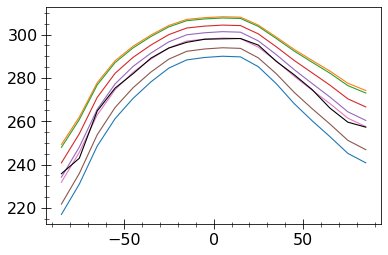

In [15]:
for i in [0,1,2,3,4,5,99]:
    plt.plot(Vars.Lat,data[i][0])
#plt.plot(Vars.Lat,data[7][0])
plt.plot(Lat_10,ZMT_10,c='k')
print(gamma)

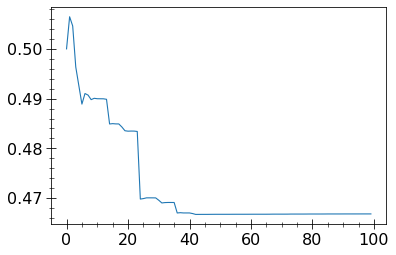

In [20]:
plt.plot(np.arange(100),P[:,0])

In [14]:
#setup={'number_of_parameters': len(P0), 'number_of_cycles': 1, 'number_of_parallels': len(P0)*2+1}
config_base=importer('Dev_Data/Optimization/Sellers.ini')
variable_importer(config_base,control=True,accuracy=1e-4)
#print(config_base)
config_base,ParasCTRL=add_sellersparameters(config_base,\
                                    parameterinterpolatorstepwise,'SellersParameterization.ini',2,0,True,True)
elevation=-0.0065*np.array(ParasCTRL[1][1])
#P_config=reshape_parameters(P0,P_pert)
labels=[['func1','m'],['func1','gamma'],['func2','factor_oc'],['func2','factor_kwv'],['func2','factor_kair']]
P_optimal=[0.4668,2.4762e-15,1.1689,1.16658,1.1942]
config=add_parameters(config_base,P_optimal,labels)
#print(config)
data=rk4alg(model_equation,config['eqparam'],config['rk4input'],config['funccomp'],progressbar=True)

Loading Configuration from: Dev_Data/Optimization/Sellers.ini
Starting controlrun with a temperature accuracy of 0.0001 K on the GMT over 1000 datapoints.
Loading Parameters from: /Home/siv32/bsc029/.local/lib/python3.6/site-packages/lowEBMs/Tutorials/Config/Data/SellersParameterization.ini


Steady State reached after 29943 steps, within 41.05894374847412 seconds
Finished controlrun over 1982.035616438356 years. Runtime: 41.0869026184082 s


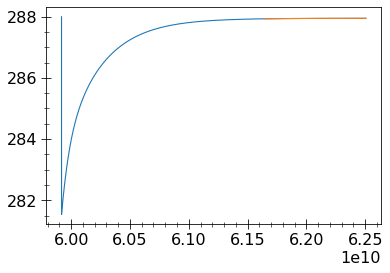

In [9]:
plt.plot(data[0],data[2])
plt.plot(data[0][-10000:],data[2][-10000:])

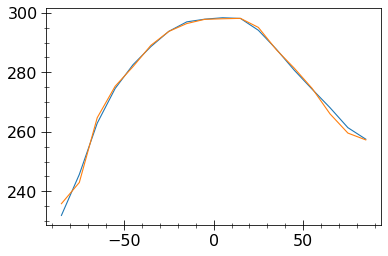

In [15]:
plt.plot(Vars.Lat,data[1][-1]+elevation)
plt.plot(Lat_10,ZMT_10)